**Understanding RNNs**

In [1]:
from tensorflow.keras.layers import SimpleRNN

SimpleRNN processes batches of sequences, like all other Keras layers, not just a single sequence. This means that it takes inputs of shape (batch_size, timesteps, input_features), rather than (timesteps, input_features).

Like all recurrent layers in Keras, **SimpleRNN can be run in two different modes:**

1. it can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape (batch_size, timesteps, output_features));
2. it can return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). These two modes are controlled by the return_sequences constructor argument.
Let's take a look at an example per each type. This one returns only the last output for each input sequence:

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()     # Embedding means text to numerical values
model.add(Embedding(10000, 32)) # the dimensionality of the embeddings(output_features), here 32. batch size 10000
model.add(SimpleRNN(32))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322080 (1.23 MB)
Trainable params: 322080 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


while this returns the full sequences of successive outputs for each timestep:

In [3]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322080 (1.23 MB)
Trainable params: 322080 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all intermediate layers to return full sequences:

Embedding layer with 10,000 as the input dimension, which means it will encode input integers within the range from 0 to 9999 (inclusive), and 32 as the output dimension, which means each integer input will be embedded into a 32-dimensional vector. This layer is commonly used in natural language processing tasks to convert discrete words (represented as integers) into continuous vectors.

In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328320 (1.25 MB)
Trainable params: 328320 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [5]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)

print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17464789/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an Embedding layer and a SimpleRNN layer:

In [6]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 28s 149ms/step - loss: 0.6484 - acc: 0.6136 - val_loss: 0.4900 - val_acc: 0.8036
Epoch 2/10
157/157 [==============================] - 22s 138ms/step - loss: 0.4257 - acc: 0.8174 - val_loss: 0.4011 - val_acc: 0.8230
Epoch 3/10
157/157 [==============================] - 23s 143ms/step - loss: 0.3195 - acc: 0.8705 - val_loss: 0.3468 - val_acc: 0.8568
Epoch 4/10
157/157 [==============================] - 23s 146ms/step - loss: 0.2692 - acc: 0.8945 - val_loss: 0.4424 - val_acc: 0.7986
Epoch 5/10
157/157 [==============================] - 23s 150ms/step - loss: 0.2198 - acc: 0.9154 - val_loss: 0.3647 - val_acc: 0.8508
Epoch 6/10
157/157 [==============================] - 23s 144ms/step - loss: 0.1657 - acc: 0.9393 - val_loss: 0.4221 - val_acc: 0.8210
Epoch 7/10
157/157 [==============================] - 23s 147ms/step - loss: 0.1232 - acc: 0.9571 - val_loss: 0.3915 - val_acc: 0.8532
Epoch 8/10
157/157 [==============================] - 2

Let's plot the validation loss and accuracy:

In [7]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')   #“bo” is for “blue dot.
    plt.plot(epochs, val_acc, 'b', label='Validation acc') #“b” is for “solid blue line.”
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

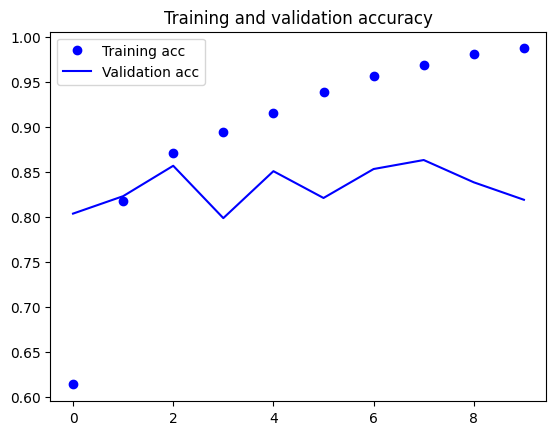

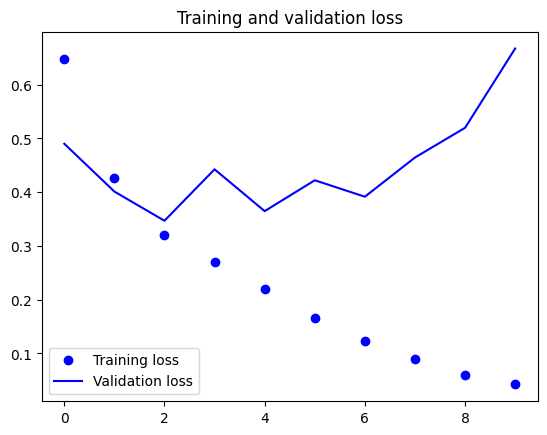

In [8]:
plot_loss_accuracy(history)